### **Libraries**

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import scipy as sp
import pandas as pd
import matplotlib as mpl
import math as mt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [162]:
drive.mount('/drive', force_remount=True)

Mounted at /drive


### **Reading Data**

In [163]:
snd = pd.read_csv("/drive/My Drive/mcdata/jla_mub_0.txt", sep = " ", header = None).values.T
cov = pd.read_csv("/drive/My Drive/mcdata/jla_mub_covmatrix.txt", header = None).values

### **Initial Parameters**

In [164]:
np.random.seed(3)
Ns = 5000                     #Total no. of samples
nburn = mt.floor(Ns/10)       #1st 10% of the samples is considered to be the burn-in phase
npar = 2                      #Total no. of parameters, h and Omega_m (Om)
nSn = len(snd[1])             #size of supernova data file
c = 3*10**8                   # speed of light in SI units
H0 = 10**5                    #Hubble's constant
sig = [0.01,0.01]             #Spread of the gaussian i.e decides the size of the proposal distribution


acc = np.zeros(npar)          #vector to hold accepted samples and total samples
muv = np.zeros(nSn)           #vecor to hold difference in distance modulus 

pars = np.zeros([Ns,npar])      #holds the values Om and h in 0th and 1st index respectively
pars[0] = [np.random.uniform(),np.random.uniform()]       #initialising with a random starting point for Om and h

accept = np.zeros([Ns,npar])      #stores accepted points
reject = np.zeros([Ns,npar])      #stores rejected points
accept[0]=pars[0]                 
reject[0]=pars[0]

### **Supernova Ia redshift vs distance modulus plot**

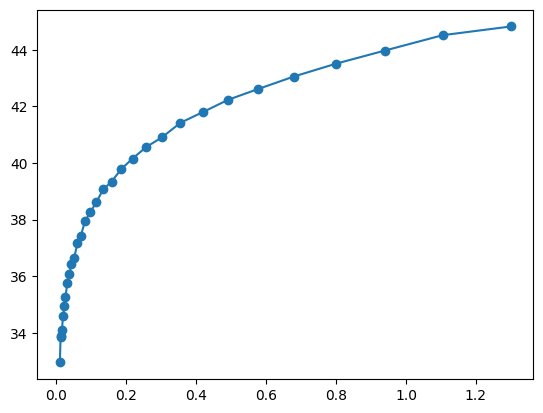

In [165]:
z = snd[0]
mu = snd[1]
plt.plot(z,mu,'o',linestyle='-')

### **MCMC sampling**

**Covariance matrix**

In [166]:
cov = np.reshape(cov,(nSn,nSn))         #reshaping (961,1) to (31,31)
invc = np.empty((nSn,nSn))
invc = np.linalg.inv(cov)               #inverse of the covariance matrix

**Likelihood and other require functions**

In [167]:
# def eta(a,Om):
#   s = ((1-Om)/Om)**(1/3)
#   eta1 = 2*mt.sqrt(s**3 + 1)*(1/a**4-0.154*s/a**3+0.4304*s**2/a**2+0.19097*s**3/a+0.066941*s**4)**(-1/8)
#   return eta1
def s(omega_m):
    return ((1-omega_m)/omega_m)**(1/3)

def eta(a,omega_m):
    term_1 = (1/a**(4)) - (0.1540*s(omega_m)/(a**(3))) + (0.4304*(s(omega_m)**2)/(a**(2)))
    term_2 = (0.19097*(s(omega_m)**3)/(a**(1))) + (0.066941*(s(omega_m)**4))
    
    return 2*np.sqrt((s(omega_m)**3) + 1)*((term_1 + term_2)**(-1/8))

def  Dls(z,Om):
  D = (c*(1+z)/H0)*(eta(1,Om)-eta(1/(1+z),Om))      #Distance at h=1
  return D

def mu_m(h,z,Om):
  mu_m = 25 - 5*np.log10(h)+5*np.log10(Dls(z,Om))       #distance modulus
  return mu_m

#Likelihood distribution in log-scale
def likl(Om,h):
  for j in range(nSn):
    muv[j] = mu[j] - mu_m(h,z[j],Om)
  likl = -0.5*np.dot(muv,np.dot(invc,muv))  
  return likl 

def uniprior(Om,h):
  if (Om<=0 or h<=0 or Om>1 or h>1):
    pri = -np.inf
  else:
    pri = 0
  return pri

def prior(Om,h):
  mu_m = 0.738
  s = 0.024
  if (Om<=0 or h<=0 or Om>1 or h>1):
    pri =  -np.inf
  elif(mu_m-5*s <= h <= mu_m+5*s) and (0<Om<1):
    pri = -0.5*(h-mu_m)**2/s**2
  else:
    pri = -np.inf
  return pri   

def prop(Om,h):
  prop = prior(Om,h) + likl(Om,h)
  return prop

def prop_uni(Om,h):
  prop = uniprior(Om,h) + likl(Om,h)
  return prop

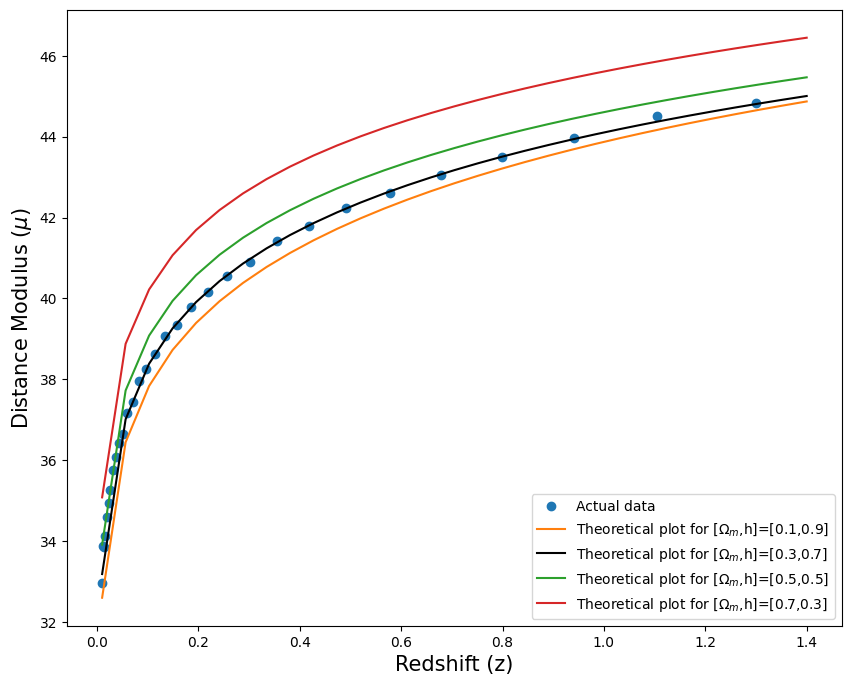

In [168]:
N = 31
z_lin = np.linspace(0.01,1.4,N)
mu_plot0 = np.zeros(N) 
mu_plot1 = np.zeros(N)
mu_plot2 = np.zeros(N)
mu_plot3 = np.zeros(N)
for i in range(N):
  mu_plot0[i] = mu_m(0.9,z_lin[i],0.1)
  mu_plot1[i] = mu_m(0.7,z_lin[i],0.3)
  mu_plot2[i] = mu_m(0.5,z_lin[i],0.5)
  mu_plot3[i] = mu_m(0.29,z_lin[i],0.706)
fig, ax = plt.subplots(figsize=(10,8))  
ax.plot(z,mu,'o', label ='Actual data')
ax.plot(z_lin,mu_plot0,label ='Theoretical plot for [$\Omega_{m}$,h]=[0.1,0.9]')
ax.plot(z_lin,mu_plot1,color='k',label ='Theoretical plot for [$\Omega_{m}$,h]=[0.3,0.7]')
ax.plot(z_lin,mu_plot2,label ='Theoretical plot for [$\Omega_{m}$,h]=[0.5,0.5]')
ax.plot(z_lin,mu_plot3,label ='Theoretical plot for [$\Omega_{m}$,h]=[0.7,0.3]')
ax.legend()
ax.set_ylabel('Distance Modulus ($\mu$)',fontsize=15)
ax.set_xlabel('Redshift (z)', fontsize=15)
plt.savefig("zvsmu.jpg", format='jpg')

### **MH MCMC with Uniform prior**

In [169]:
def MH_un(initial,sigma):
  global accp
  global rej
  sigOm, sigh = sigma
  Om0,h0 = initial 
  htrial = np.random.normal(h0,sigh)              #drawing trial point considering a gaussian centered at previous point
  Omtrial = np.random.normal(Om0,sigOm) 
  u = np.log(np.random.uniform())
  accept = prop_uni(Omtrial,htrial)-prop_uni(Om0,h0)      #minus in between since it is log-scaled
  if accept>0:
    hnew = htrial
    Omnew = Omtrial
    a = 1                   #flags to 1 if the point is accepted
    paras = [Omnew,hnew]
    accp = [Omnew,hnew]           #stores all the accepted points
    # targ = likl(Omtrial,htrial)
  else:  
    if u<=accept:
      hnew = htrial
      Omnew = Omtrial
      a = 1
      paras = [Omnew,hnew]
      accp = [Omnew,hnew]
      # targ = likl(Omtrial,htrial)
    else:
      hnew = h0
      Omnew = Om0
      a = 0         #flags to 0 if the point is rejected
      paras = [Omnew,hnew]
      rej = [Omtrial,htrial]  #stores all the rejected points
      # targ = likl(Omtrial,htrial)
  return paras, a,accp, rej

In [170]:
#loop to run the MH sampling for Ns samples
for i in range(Ns-1):
  pars[i+1],a, accept[i+1],reject[i+1] = MH_un(pars[i],sig) 
  acc = acc + np.array((a,1))

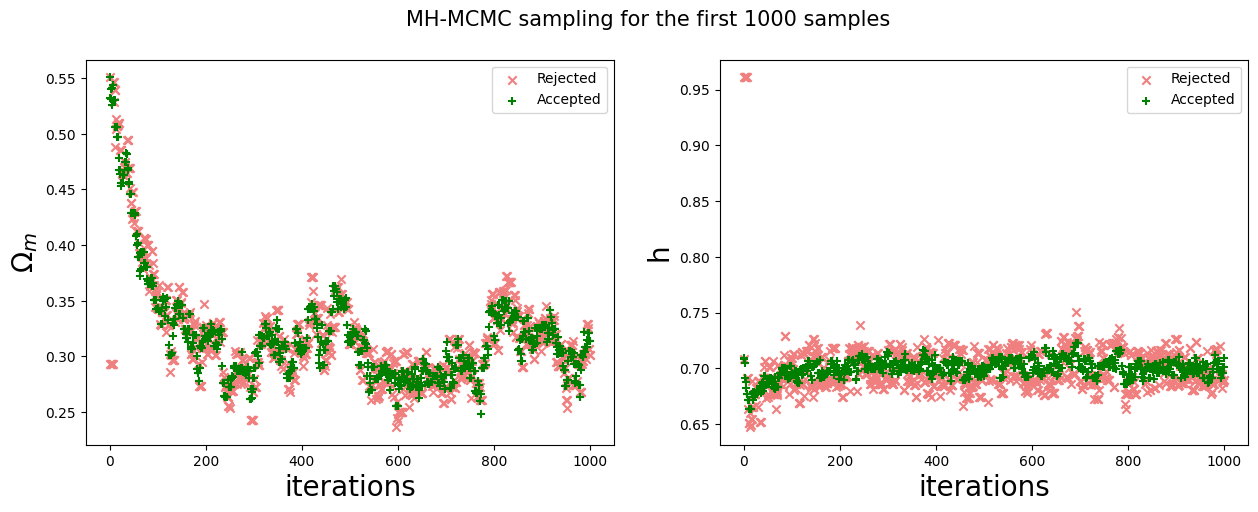

In [171]:
n = 0.2
Ns25 = int(n*Ns)
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(np.linspace(0,Ns25,Ns25),reject[0:Ns25:,0],color='lightcoral',marker="x", label = 'Rejected')
axs[0].scatter(np.linspace(0,Ns25,Ns25),accept[0:Ns25:,0],color='g', marker = "+", label = 'Accepted')
axs[1].scatter(np.linspace(0,Ns25,Ns25),reject[0:Ns25:,1],color='lightcoral',marker="x", label = 'Rejected')
axs[1].scatter(np.linspace(0,Ns25,Ns25),accept[0:Ns25:,1],color='g', marker = "+", label = 'Accepted')
axs[0].set_xlabel('iterations', fontsize = 20)
axs[0].set_ylabel('$\Omega_{m}$', fontsize = 20)
axs[1].set_xlabel('iterations', fontsize = 20)
axs[1].set_ylabel('h', fontsize = 20)
axs[0].legend()
axs[1].legend()
# axs[0].set_ylim(0.4,0.7)
# axs[1].set_ylim(0.6,0.8)
fig.suptitle('MH-MCMC sampling for the first %d samples' %Ns25, fontsize = 15)
plt.savefig("acc&rej.jpg", format='jpg')

In [172]:
mean_Om = np.mean(pars[nburn:,0])     #mean of Om
mean_h = np.mean(pars[nburn:,1])      #mean of h
std_Om = np.std(pars[nburn:,0])       #standard deviation of Om
std_h = np.std(pars[nburn:,1])        #standard deviation of h
paras = np.stack((pars[nburn:,0],pars[nburn:,1]))
cova = np.cov(paras)                   #covariance of Om and h
# invco = np.linalg.inv(cova)
print([mean_Om,std_Om],[mean_h,std_h],cova)

[0.30012225269218146, 0.03346941758545224] [0.7024049478660319, 0.007277538056620801] [[ 1.12045090e-03 -1.54811706e-04]
 [-1.54811706e-04  5.29743322e-05]]


In [173]:
accept_avg = acc[0]/acc[1]    #average acceptance
accept_avg,acc

(0.5071014202840568, array([2535., 4999.]))

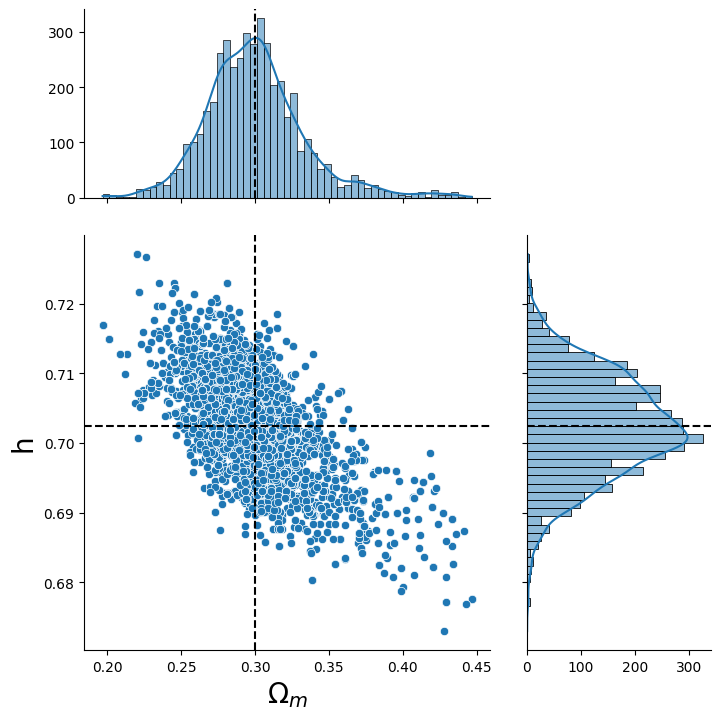

In [174]:
g = sns.JointGrid(data=pars, x=pars[nburn:,0], y=pars[nburn:,1], height=7, ratio=2, marginal_ticks=True)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.histplot, kde=True)
g.refline(x=mean_Om, y=mean_h,color='k')
g.set_axis_labels(xlabel='$\Omega_{m}$', ylabel='h', fontsize=20)
g.savefig("Joint_Dist.jpg", format='jpg')

### **MH MCMC with Gaussian Prior**

In [175]:
np.random.seed(3)
acc = np.zeros(npar)          #vector to hold accepted samples and total samples
muv = np.zeros(nSn)           #vecor to hold difference in distance modulus 

pars = np.zeros([Ns,npar])      #holds the values Om and h in 0th and 1st index respectively
pars[0] = np.random.uniform(size=2)       #initialising with a random starting point for Om and h

accept = np.zeros([Ns,npar])      #stores accepted points
reject = np.zeros([Ns,npar])      #stores rejected points
accept[0]=pars[0]                 
reject[0]=pars[0]

In [176]:
def MH(initial,sigma):
  global accp
  global rej
  sigOm, sigh = sigma
  Om0,h0 = initial 
  htrial = np.random.normal(h0,sigh)              #drawing trial point considering a gaussian centered at previous point
  Omtrial = np.random.normal(Om0,sigOm) 
  u = np.log(np.random.uniform())
  accept = prop(Omtrial,htrial)-prop(Om0,h0)      #minus in between since it is log-scaled
  if accept>0:
    hnew = htrial
    Omnew = Omtrial
    a = 1                   #flags to 1 if the point is accepted
    paras = [Omnew,hnew]
    accp = [Omnew,hnew]           #stores all the accepted points
    # targ = likl(Omtrial,htrial)
  else:  
    if u<=accept:
      hnew = htrial
      Omnew = Omtrial
      a = 1
      paras = [Omnew,hnew]
      accp = [Omnew,hnew]
      # targ = likl(Omtrial,htrial)
    else:
      hnew = h0
      Omnew = Om0
      a = 0         #flags to 0 if the point is rejected
      paras = [Omnew,hnew]
      rej = [Omtrial,htrial]  #stores all the rejected points
      # targ = likl(Omtrial,htrial)
  return paras, a,accp, rej

In [177]:
#loop to run the MH sampling for Ns samples
for i in range(Ns-1):
  pars[i+1],a, accept[i+1],reject[i+1] = MH(pars[i],sig) 
  acc = acc + np.array((a,1))  

**Acceptance and Rejection**

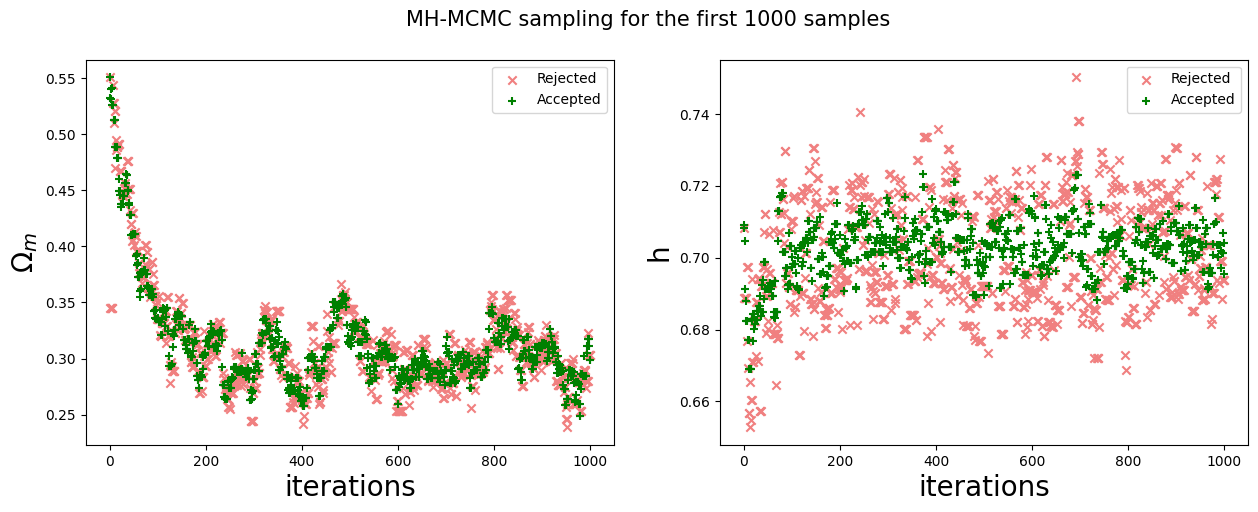

In [178]:
n = 0.2
Ns25 = int(n*Ns)
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(np.linspace(0,Ns25,Ns25),reject[0:Ns25:,0],color='lightcoral',marker="x", label = 'Rejected')
axs[0].scatter(np.linspace(0,Ns25,Ns25),accept[0:Ns25:,0],color='g', marker = "+", label = 'Accepted')
axs[1].scatter(np.linspace(0,Ns25,Ns25),reject[0:Ns25:,1],color='lightcoral',marker="x", label = 'Rejected')
axs[1].scatter(np.linspace(0,Ns25,Ns25),accept[0:Ns25:,1],color='g', marker = "+", label = 'Accepted')
axs[0].set_xlabel('iterations', fontsize = 20)
axs[0].set_ylabel('$\Omega_{m}$', fontsize = 20)
axs[1].set_xlabel('iterations', fontsize = 20)
axs[1].set_ylabel('h', fontsize = 20)
axs[0].legend()
axs[1].legend()
# axs[0].set_ylim(0.4,0.7)
# axs[1].set_ylim(0.6,0.8)
fig.suptitle('MH-MCMC sampling for the first %d samples' %Ns25, fontsize = 15)
plt.savefig("acc&rej1.jpg", format='jpg')

**Numerical values**

In [179]:
mean_Om = np.mean(pars[nburn:,0])     #mean of Om
mean_h = np.mean(pars[nburn:,1])      #mean of h
std_Om = np.std(pars[nburn:,0])       #standard deviation of Om
std_h = np.std(pars[nburn:,1])        #standard deviation of h
paras = np.stack((pars[nburn:,0],pars[nburn:,1]))
cova = np.cov(paras)                   #covariance of Om and h
invco = np.linalg.inv(cova)
print([mean_Om,std_Om],[mean_h,std_h],cova)

[0.2902374776901467, 0.030772848982909277] [0.7056433592614467, 0.006957924070263544] [[ 9.47178719e-04 -1.25741983e-04]
 [-1.25741983e-04  4.84234681e-05]]


In [180]:
accept_avg = acc[0]/acc[1]    #average acceptance
accept_avg,acc

(0.5079015803160633, array([2539., 4999.]))

**Joint and Marginal Distribution**

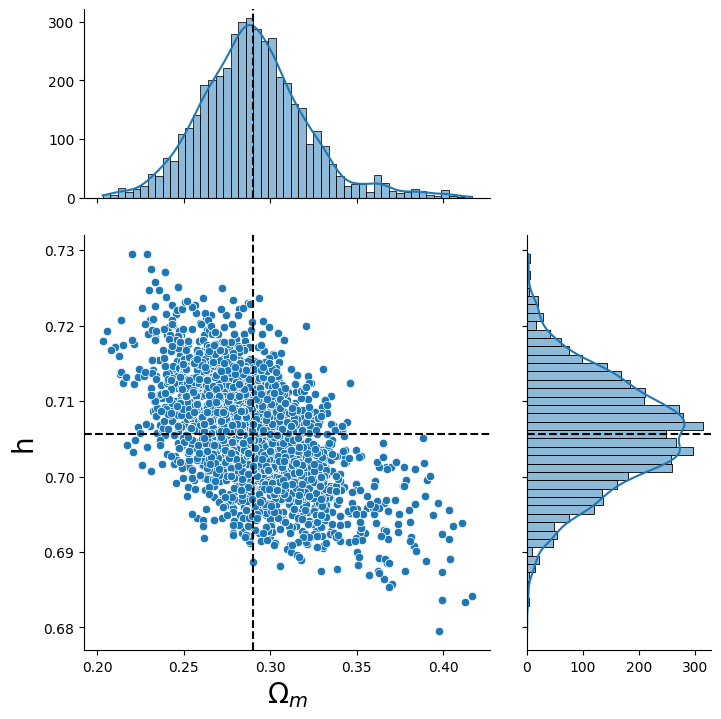

In [181]:
g = sns.JointGrid(data=pars, x=pars[nburn:,0], y=pars[nburn:,1], height=7, ratio=2, marginal_ticks=True)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.histplot, kde=True)
g.refline(x=mean_Om, y=mean_h,color='k')
g.set_axis_labels(xlabel='$\Omega_{m}$', ylabel='h', fontsize=20)
g.savefig("Joint_Dist1.jpg", format='jpg')

### **Gelman Rubin Convergence Test**

In [182]:
def GRC(n_chains):
  chain_mean_Om = np.zeros(n_chains)
  chain_mean_h = np.zeros(n_chains)
  chain_var_Om = np.zeros(n_chains)
  chain_var_h = np.zeros(n_chains)
  for j in range(n_chains):
    acc = np.zeros(npar)          #vector to hold accepted samples and total samples
    muv = np.zeros(nSn)           #vecor to hold difference in distance modulus 

    pars = np.zeros([Ns,npar])      #holds the values Om and h in 0th and 1st index respectively
    pars[0] = np.random.uniform(size=2)      #initialising with a random starting point for Om and h

    accept = np.zeros([Ns,npar])      #stores accepted points
    reject = np.zeros([Ns,npar])      #stores rejected points
    accept[0]=pars[0]                 
    reject[0]=pars[0]
    for i in range(Ns-1):
      pars[i+1],a, accept[i+1],reject[i+1] = MH(pars[i],sig) 
      # acc = acc + np.array((a,1))
    Nb = len(pars[nburn:,0])  
    mean_Om = np.mean(pars[nburn:,0])     
    mean_h = np.mean(pars[nburn:,1])      
    var_Om = np.var(pars[nburn:,0])*Nb/(Nb-1)      
    var_h = np.var(pars[nburn:,1])*Nb/(Nb-1) 
    chain_mean_Om[j] = mean_Om         
    chain_mean_h[j] = mean_h
    chain_var_Om[j] = var_Om
    chain_var_h[j] = var_h
  grand_mean_Om = np.mean(chain_mean_Om)
  grand_mean_h = np.mean(chain_mean_h)
  mean_var_Om = np.mean(chain_var_Om)
  mean_var_h = np.mean(chain_var_h) 
  var_var_Om = np.var(chain_var_Om)*n_chains*Nb/(n_chains-1)
  var_var_h = np.var(chain_var_h)*n_chains*Nb/(n_chains-1)   

  R_h =  (((Nb-1)/Nb)*mean_var_h + var_var_h/Nb)/mean_var_h
  R_Om =  (((Nb-1)/Nb)*mean_var_Om + var_var_Om/Nb)/mean_var_Om
  return R_Om, R_h

In [183]:
GRC(30)

(1.0004185963428331, 0.9998112294732632)

### **Hamiltonian Monte Carlo** - Not Exacty working


In [184]:
acc = np.zeros(npar)          #vector to hold accepted samples and total samples
muv = np.zeros(nSn)           #vecor to hold difference in distance modulus 

pars = np.zeros([Ns,npar])      #holds the values Om and h in 0th and 1st index respectively
pars[0] = [np.random.uniform(),np.random.uniform()]       #initialising with a random starting point for Om and h

accept = np.zeros([Ns,npar])      #stores accepted points
reject = np.zeros([Ns,npar])      #stores rejected points
accept[0]=pars[0]                 
reject[0]=pars[0]

In [185]:
def GradU(Om,h,inv_cov):
  A = np.array([[Om-mean_Om],[h-mean_h]])
  gradU = np.matmul(np.transpose(A),inv_cov)
  return gradU

In [186]:
# def GradU(Om,h,inv_cov):
#   inv = inv_cov
#   gradU = [[inv[0][0]*(Om-mean_Om)+inv[0][1]*(h-mean_h)],[inv[1][0]*(Om-mean_Om)+inv[1][1]*(h-mean_h)]]
#   return np.array(gradU)

In [187]:
def leap(q_init,p_init,inv_cov,path_len,step_size):
  Om,h = q_init
  p_Om,p_h = p_init
  gradU = GradU(Om,h,inv_cov).reshape(2,1)
  p_Om -= step_size * gradU[0] / 2  # half step
  p_h -= step_size * gradU[1] / 2  # half step
  for _ in range(int(path_len / step_size) - 1):
       Om += step_size * p_Om  # whole step
       h += step_size * p_h  # whole step
       gradU = GradU(Om,h,inv_cov).reshape(1,2)
       p_Om -= step_size * gradU[0][0]  # whole step       
       p_h -= step_size * gradU[0][1]  # whole step
  Om += step_size * p_Om  # whole step
  h += step_size * p_h  # whole step 
  gradU = GradU(Om,h,inv_cov).reshape(1,2)
  p_Om -= step_size * gradU[0][0] / 2  # half step
  p_h -= step_size * gradU[0][1] / 2  # half step    
  theta_new = [Om,h]    
  p_new = [p_Om,p_h] 
  return theta_new, -1*p_new

In [188]:
def ham(theta,p):
  H = -prop(theta[0],theta[1]) + np.dot(p,p)/2
  return np.log(H)

In [189]:
def HMC(initial,sigma,inv_cov,path_len,step_size):
  global accp
  global rej
  p = np.random.normal(0,1,size=2)
  theta_new,p_new = leap(initial,p,inv_cov,path_len,step_size)
  u = np.log(np.random.uniform())
  accept = ham(initial,p)-ham(theta_new,p_new)      #minus in between since it is log-scaled
  if accept>0:
    a = 1                   #flags to 1 if the point is accepted
    paras = theta_new
    accp = theta_new           #stores all the accepted points
    # targ = likl(Omtrial,htrial)
  else:  
    if u<accept:
      a = 1
      paras = theta_new
      accp = theta_new           
      # targ = likl(Omtrial,htrial)
    else:
      a = 0         #flags to 0 if the point is rejected
      paras = initial
      rej = initial  #stores all the rejected points
      # targ = likl(Omtrial,htrial)
  return paras, a,accp, rej

In [190]:
for i in range(Ns-1):
  pars[i+1],a, accept[i+1],reject[i+1] = HMC(pars[i],sig,invco,4,0.25) 
  acc = acc + np.array((a,1)) 
  # print(i)

In [191]:
mean_Om = np.mean(pars[nburn:,0])     #mean of Om
mean_h = np.mean(pars[nburn:,1])      #mean of h
std_Om = np.std(pars[nburn:,0])       #standard deviation of Om
std_h = np.std(pars[nburn:,1])        #standard deviation of h
paras = np.stack((pars[nburn:,0],pars[nburn:,1]))
cova = np.cov(paras)                   #covariance of Om and h
# invco = np.linalg.inv(cova)
print([mean_Om,std_Om],[mean_h,std_h],cova)

[0.2746510223745346, 5.551115123125783e-17] [0.9498720518684332, 2.220446049250313e-16] [[3.08217284e-33 1.23286914e-32]
 [1.23286914e-32 4.93147654e-32]]


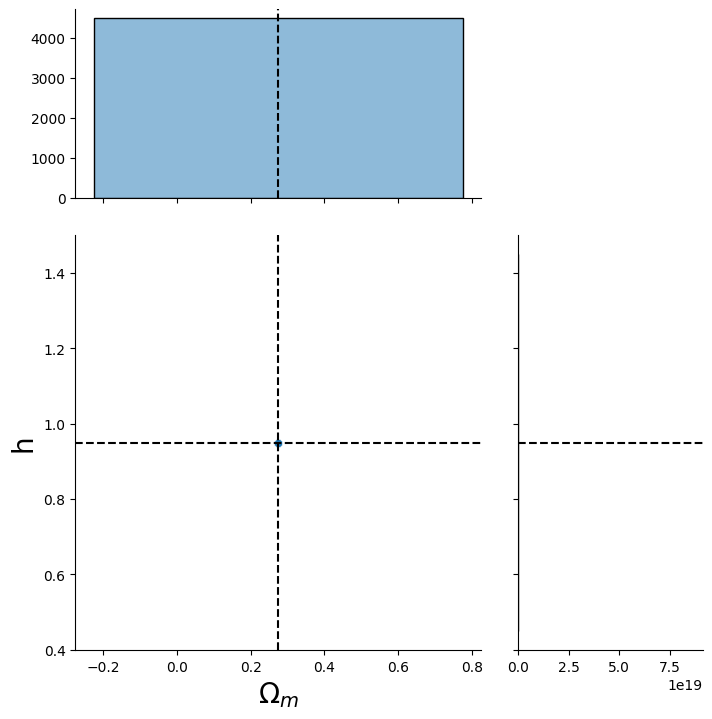

In [192]:
g = sns.JointGrid(data=pars, x=pars[nburn:,0], y=pars[nburn:,1], height=7, ratio=2, marginal_ticks=True)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.histplot, kde=True)
g.refline(x=mean_Om, y=mean_h,color='k')
g.set_axis_labels(xlabel='$\Omega_{m}$', ylabel='h', fontsize=20)
# g.savefig("Joint_Dist.jpg", format='jpg')